In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
import pandas as pd
import copy
from HINTS import *
from HINTS_fn_Student_t import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

# Student t distribution

- overview https://en.wikipedia.org/wiki/Student%27s_t-distribution
- in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html 

A 'non-standard' or 'location-scale' t distribution has the following params:

- &nu; (int >=1) degrees of freedom
- &mu; mean & mode
- &tau; scale parameter



0.990246814525618  should approx. equal  1.0
1.1573093850798888  should approx. equal  1.1547005383792515


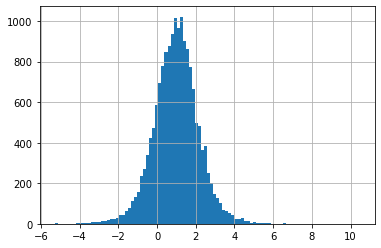

In [3]:
# generate some example data in numpy
mu = 1.0
tau = 1.0 # not the same as sigma because the standard t has variance nu/(nu-2), if this exists
nu = 8 # NB if wer choose low values of nu (dof) we get a very tight distribution
log2N = 14 # size of dataset
NX = 2 ** log2N


eg = mu + np.random.standard_t(nu, size = NX) * tau

print(np.mean(eg), " should approx. equal ", mu)
print(np.std(eg), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts, bins = np.histogram(eg, bins = 100)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.grid() # NB if we make nu smaller we get much fatter tails

0.9918377249339972  should approx. equal  1.0
1.1619439895734593  should approx. equal  1.1547005383792515


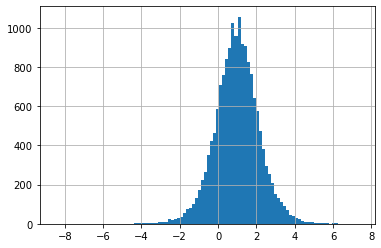

In [12]:
# scipy

np.random.seed(seed=4) # depending on seed, the max likelihood nu may or may not be the same as the nu we used

from scipy.stats import t # non central t

eg2 = t.rvs(nu, loc = mu, scale = tau, size = NX)

print(np.mean(eg2), " should approx. equal ", mu)
print(np.std(eg2), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts2, bins2 = np.histogram(eg2, bins = 100)
_ = plt.hist(bins2[:-1], bins2, weights=counts2)
plt.grid() # NB if we make nu smaller we get much fatter tails

# all looks fine

In [13]:
# log likelihood example (it's not very sensitive to dof!)
print(nu)
mll = t(nu, loc = mu, scale = tau).logpdf(eg2).sum() # likelihood for actual params
print(mll) # actual
print("Neighbours - MLL: will usually be negative (less likely) ") 
print(t(nu-1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu+1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu - 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu + 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau * 1.05).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau / 1.05).logpdf(eg2).sum() - mll)

# NB if we see -10, then it is exp(-10) less likely. So even with N = 10000, the posterior on DOF is very tight 

8
-25489.196478797254
Neighbours - MLL: will usually be negative (less likely) 
-3.7150665039007436
-5.470751554828894
-12.228713015985704
-21.14222245550627
-17.818551739175746
-39.46836741266452


In [14]:
# numpy version - would need log gamma simplified
#
#def t_log_prob(nu, mu, tau, values):
#    y = (values - mu) / tau
#    z = np.log(tau) + 0.5 * np.log(nu) + 0.5 * np.log(np.pi) + np.lgamma(0.5 * nu) - np.lgamma(0.5 * (nu + 1.0)) # partition
#    return (-0.5 * (nu + 1.0) * np.log1p(y * y / nu) - z)
#
#t_log_prob(nu, mu, tau, eg2[:1])

import torch
from torch.distributions import StudentT

t1 = StudentT(nu, mu, tau)
print(t1.log_prob(torch.Tensor(eg2[:1])),  t(nu, mu, tau).logpdf(eg2[:1]))
tt = torch.Tensor(eg2[:64])
%timeit t1.log_prob(tt) # 4 times faster than scipy for 64
%timeit t1.log_prob(torch.Tensor(eg2[:1000])) # 283 us


tensor([-0.9513]) [-0.95132977]
236 µs ± 8.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
275 µs ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:

# say we have NX = 2**14 datapoints: arrange as 1024 scenarios each with 16, or 256 by 64
# HINTS will have biggest advantage for small leaf size (mixing time in terms of leaf evals)

#LEAF_SIZE = 64 ## vectorise at leaves for speed
#NUM_SCENARIOS = NX//LEAF_SIZE
#print(NUM_SCENARIOS, "scenarios by", LEAF_SIZE, "in each leaf =", NX, "(dataset size)")

#data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
#print(data.shape)

# just make sure we reset these each time
mu = 1.0
tau = 1.0 # not the same as sigma because the standard t has variance nu/(nu-2), if this exists
nu = 8 # NB if wer choose low values of nu (dof) we get a very tight distribution



import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


args.additive = True # True gives natural tempering, False might make lower levels overconfident ... better to use Temp explicitly
inverse_temper = False # cancel some of the natural tempering - difficult to tune the tempering hierarchy.. what we have is safe
# note could try averaging not tempering so acceptance at leaf less likely to be rejected higher up??
args.T = 1.0
args.dT = 0.0


if True: # put True in for HINTS, False for simple MCMC where evaluations use all data
    args.levels = 5
    if inverse_temper:
        args.Ts = np.flip(np.array([2 ** (-0.5 * l) for l in range(args.levels+1)]))
        #args.Ts = np.ones([args.levels+1]) # test (ok)
    log_branch_factor = 2
    N_0 = 1 # * batches of 16 or 64 at leaf 
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    args.LEAF_SIZE = 16
    args.iterations = 750
    args.expt = 'HINTS_downsample' + ('' if args.additive else '_averager') + ('_it' if inverse_temper else '') #'HINTS100'
    args.proposal_sigma = 0.01/2 # surprisingly reducing this further doesn't help (with deeper tree ... tempering effect
    args.skip_after_accept = False
    args.downsample = 2 # do not visit each scenario each time .. NB could be more systematic (with visiting every scenario) but that may not help
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 16 # for efficiency
    args.design = np.array([NUM_SCENARIOS])
    args.LEAF_SIZE = 1024 # for efficiency
    args.iterations = 1000 # NB this is not comparable with HINTS iterations ... check the g.counter for actual leaf node (scenario) function evaluations
    args.expt = 'MCMC_flat' #'MCMC500'
    args.proposal_sigma = 0.01 # bigger than HINTS because it struggles with burn in
    args.skip_after_accept = False

print(NUM_SCENARIOS * args.LEAF_SIZE) # should be same for both options


# design now has levels + 1 entries


print(args.__dict__)

16384
{'additive': True, 'T': 1.0, 'dT': 0.0, 'levels': 5, 'design': array([1, 4, 4, 4, 4, 4]), 'LEAF_SIZE': 16, 'iterations': 750, 'expt': 'HINTS_downsample', 'proposal_sigma': 0.005, 'skip_after_accept': False, 'downsample': 2}


In [17]:
args.id = 0
args.NUM_SCENARIOS = NUM_SCENARIOS
args.mu = mu
args.tau = tau
args.nu = nu



In [365]:
from parallel_funcs_t import run_t_sampler
args1 = copy.deepcopy(args)
args1.iterations = 10
%time run_t_sampler(args1)

RESET
5
[   1    4   16   64  256 1024]
1024
[1. 1. 1. 1. 1. 1.]
0 initial state Student t state variable: nu = 13,  mu = 1.281, tau = 1.076
Wall time: 9.89 s


,nu,mu,tau,acceptances,rejections,evals_cache,evaluations
0,13,1.280699,1.075701,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0,0
1,9,1.245717,1.062732,"[32, 13, 7, 4, 2, 1]","[0, 3, 1, 0, 0, 0]",48192,4032
2,10,1.215997,1.027704,"[64, 28, 12, 7, 4, 2]","[0, 4, 4, 1, 0, 0]",78592,8064
3,10,1.196643,1.014824,"[96, 44, 18, 10, 6, 3]","[0, 4, 6, 2, 0, 0]",109312,12096
4,7,1.189739,1.025116,"[126, 59, 22, 13, 8, 4]","[2, 5, 10, 3, 0, 0]",130208,16128
5,8,1.156173,1.030909,"[158, 74, 29, 15, 10, 5]","[2, 6, 11, 5, 0, 0]",153952,20160
6,8,1.150283,1.048388,"[190, 90, 36, 17, 11, 6]","[2, 6, 12, 7, 1, 0]",179808,24192
7,7,1.130204,1.044123,"[222, 104, 43, 21, 13, 7]","[2, 8, 13, 7, 1, 0]",211680,28224
8,9,1.108329,1.037968,"[253, 119, 51, 24, 15, 8]","[3, 9, 13, 8, 1, 0]",242832,32256
9,9,1.108329,1.037968,"[285, 133, 58, 27, 15, 9]","[3, 11, 14, 9, 3, 0]",257296,36288


In [366]:
# parallel runs : everything goes in args

PARALLEL = 32 # replace with 100 after testing (I only have 4 cpus so I use this for testing)

# for a quick test run with fewer iterations

#pip install parallelbar
from parallelbar import progress_map

tasks = []
for i in range(PARALLEL): 
    args.id = i
    tasks.append(copy.deepcopy(args))   

ok, failures = progress_map(run_t_sampler, tasks, process_timeout = 14400, error_behavior='coerce', return_failed_tasks=True)

# you can watch progress on the command line output too

print(len(ok), "successes")
print(len(failures), "failures")
if len(failures) >0:
    print(failures)
# check the first result dataframe
print(ok[0].info())

DONE:   0%|          | 0/32 [00:00<?, ?it/s]

32 successes
0 failures
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nu           751 non-null    int32  
 1   mu           751 non-null    float64
 2   tau          751 non-null    float64
 3   acceptances  751 non-null    object 
 4   rejections   751 non-null    object 
 5   evals_cache  751 non-null    int64  
 6   evaluations  751 non-null    int64  
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 38.3+ KB
None


In [368]:
#res_HINTS[0][['evaluations', 'evals_cache']].plot()
#res_MCMC[0][['evaluations', 'evals_cache']].plot()
# evals_cache now scaled up by LEAF SIZE


In [369]:
import pickle
fname = args.expt + "_" + str(PARALLEL) + ".pkl"
print("Saving", fname)
pickle.dump(ok, open(fname, "wb" )) # was 100.pkl for main runs with e1, e2

Saving HINTS_downsample_32.pkl


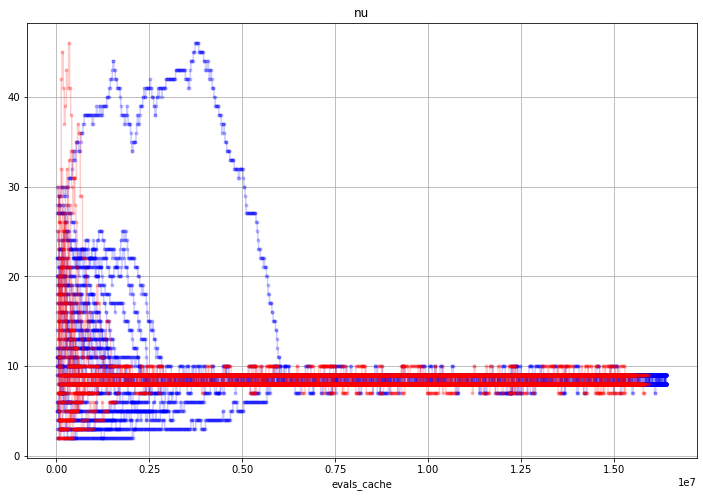

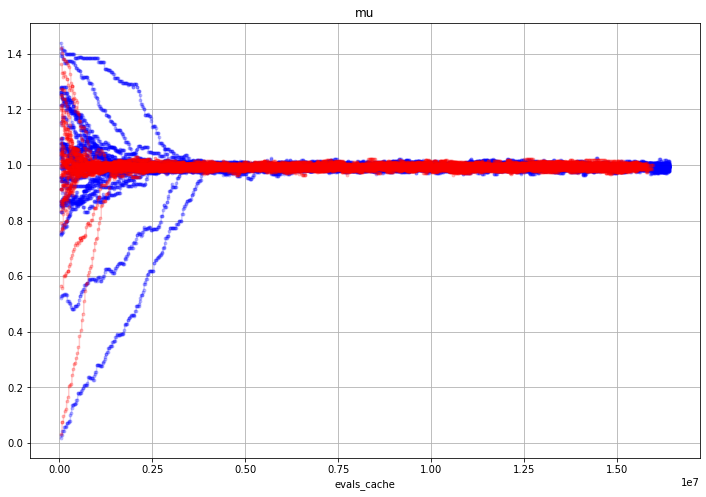

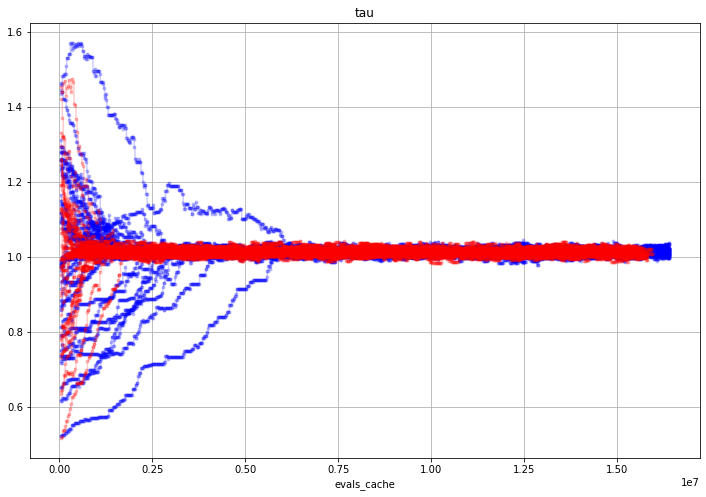

In [18]:
# reload 
import pickle

res_HINTS = pickle.load(open("HINTS_downsample_32.pkl", "rb"))
#res_HINTS = pickle.load(open("HINTS_downsample_it_16.pkl", "rb"))
res_MCMC = pickle.load(open("MCMC_flat_32.pkl", "rb"))


post_bi = False # post burn in
start = 150000 if post_bi else 0

for sx in ['nu', 'mu', 'tau']:
    plt.figure(figsize = [12, 8])
    for run, df in enumerate(res_MCMC):
        df[df.evals_cache > start].set_index('evals_cache')[sx].plot(color = 'blue', alpha = 0.2, marker = '.', drawstyle = 'steps-post')
    for run, df in enumerate(res_HINTS):
        df[df.evals_cache > start].set_index('evals_cache')[sx].plot(color = 'red', alpha = 0.2, marker = '.', drawstyle = 'steps-post')
    plt.grid()
    plt.title(sx)
    #plt.xlim(start, res_MCMC[-1].evals_cache.iloc[-1])

# TO DO: test skip after accept
    

In [19]:
# get true marginals 

# nu range 1 to 20
# mu 0.9 to 1.1
# tau 0.5 to 1.5 

# grid for joint
gnu = range(1,21)
gmu = np.arange(0.95, 1.050001, 0.0025)
gtau = np.arange(0.95, 1.050001, 0.0025)

joint = np.zeros([len(gnu), len(gmu), len (gtau)])

seed(4) # just happens to give us data where MLL nu is actual nu
data = t.rvs(args.nu, loc = args.mu, scale = args.tau, size =[args.NUM_SCENARIOS, args.LEAF_SIZE])

for ni, nu in enumerate(gnu):
    print(ni, nu)
    for mi, mu in enumerate(gmu):
        for ti, tau in enumerate(gtau):
            #g.evaluate(StateT(nu, mu, tau), )
            joint[ni, mi, ti] = StudentT(nu, mu, tau).log_prob(torch.Tensor(data)).sum()



0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20


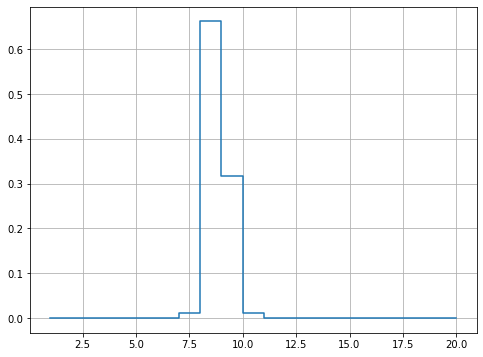

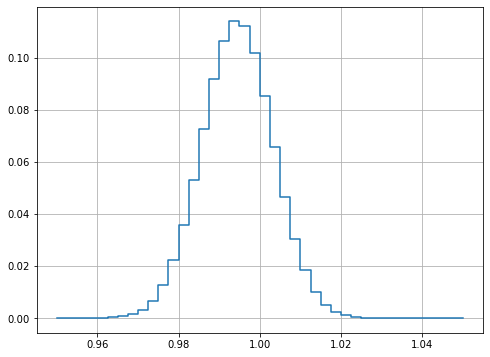

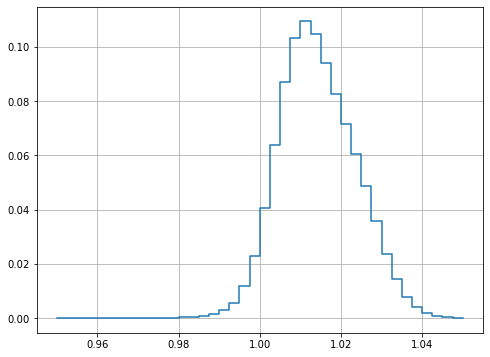

In [20]:
jpdf = np.exp(joint - np.max(joint))
jpdf /= jpdf.sum()

marginal_nu = np.sum(jpdf, axis = (1,2))
marginal_mu = np.sum(jpdf, axis = (0,2))
marginal_tau = np.sum(jpdf, axis = (0,1))

plt.figure(figsize = [8,6])
plt.plot(gnu, marginal_nu, drawstyle = 'steps-post')
plt.grid()
plt.figure(figsize = [8,6])
plt.plot(gmu, marginal_mu, drawstyle = 'steps-post')
plt.grid()
plt.figure(figsize = [8,6])
plt.plot(gtau, marginal_tau, drawstyle = 'steps-post')
plt.grid()


In [28]:
# evaluate sample against this
all_HINTS = np.concatenate([df_HINTS['tau'][250:].values for df_HINTS in res_HINTS])
all_MCMC = np.concatenate([df_MCMC['tau'][333:].values for df_MCMC in res_MCMC])


(0.98, 1.05)

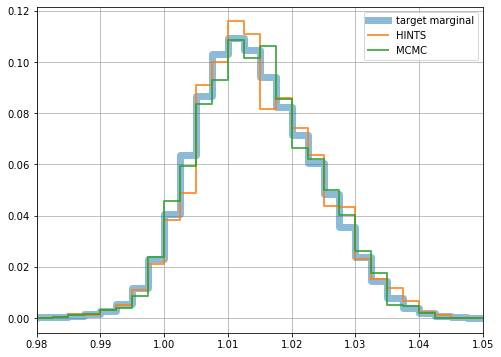

In [30]:
sample_tau = np.array(np.histogram(all_HINTS, len(gtau), (gtau[0], gtau[-1]))[0], dtype = float)
sample_tau /= np.sum(sample_tau)
MCMC_sample_tau = np.array(np.histogram(all_MCMC, len(gtau), (gtau[0], gtau[-1]))[0], dtype = float)
MCMC_sample_tau /= np.sum(MCMC_sample_tau)
plt.figure(figsize = [8,6])
plt.plot(gtau, marginal_tau, drawstyle = 'steps-post', label = 'target marginal', alpha = 0.5, linewidth = 7)
plt.plot(gtau, sample_tau, drawstyle = 'steps-post', label = 'HINTS', alpha = 0.8, linewidth = 2)
plt.plot(gtau, MCMC_sample_tau, drawstyle = 'steps-post', label = 'MCMC', alpha = 0.8, linewidth = 2)
plt.grid()
plt.legend()
plt.xlim(0.98, 1.05)

In [375]:
# rolling kl divergence on second half over evals so far?
# or by period (adjusting for evals cache)

from scipy.special import kl_div

print(kl_div(sample_tau, marginal_tau).sum(), kl_div(MCMC_sample_tau, marginal_tau).sum())



#for e_min in range(0, 250000,  
def kl(dfs, col, e_min, e_max, truth, grid):
    samp = np.concatenate([df[df.evals_cache.between(e_min, e_max)][col] for df in dfs])
    hist = np.array(np.histogram(samp, len(grid), (grid[0], grid[-1]))[0], dtype = float) + 1.0 # add 1 for expectation under dirichilet
    return(kl_div(truth, hist/np.sum(hist)).sum())

def kl_discrete(dfs, col, e_min, e_max, truth, grid):
    samp = np.concatenate([df[df.evals_cache.between(e_min, e_max)][col] for df in dfs])
    samp = np.clip(samp, a_min = grid[0], a_max = grid[-1])
    hist = np.array(np.bincount(samp - grid[0], minlength = 1 + grid[-1] - grid[0]), dtype = float) + 1.0
    return(kl_div(truth, hist/np.sum(hist)).sum())


def wasserstein(dfs, col, e_min, e_max, truth, grid):
    samp = np.concatenate([df[df.evals_cache.between(e_min, e_max)][col] for df in dfs])
    hist = np.array(np.histogram(samp, len(grid), (grid[0], grid[-1]))[0], dtype = float)
    true_cdf = np.cumsum(truth)
    samp_cdf = np.cumsum(hist/np.sum(hist))
    return(np.mean(np.abs(true_cdf - samp_cdf)))




0.03003747848895169 0.07816476138683981


In [376]:
metric = kl
metric_discrete = kl_discrete


In [377]:
sqrte = np.arange(500, 4000, 50)
e2s = sqrte * sqrte
e1s = (e2s * 3) // 4


Text(0.5, 1.0, '$\\tau$')

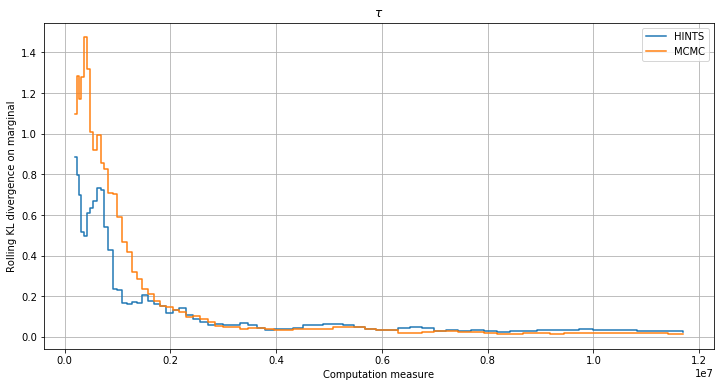

In [378]:
h_roll_kl = [metric(res_HINTS, 'tau', e1, e2, marginal_tau, gtau) for e1, e2 in zip(e1s, e2s)]
mcmc_roll_kl = [metric(res_MCMC, 'tau', e1, e2, marginal_tau, gtau) for e1, e2 in zip(e1s, e2s)]


plt.figure(figsize = [12, 6])
plt.plot(e1s, h_roll_kl, drawstyle = 'steps-post', label = 'HINTS')
plt.plot(e1s, mcmc_roll_kl, drawstyle = 'steps-post', label = 'MCMC')
#plt.semilogx()
plt.grid()
plt.legend()
plt.ylabel('Rolling KL divergence on marginal')
plt.xlabel('Computation measure')
plt.title(r'$\tau$')

Text(0.5, 1.0, '$\\mu$')

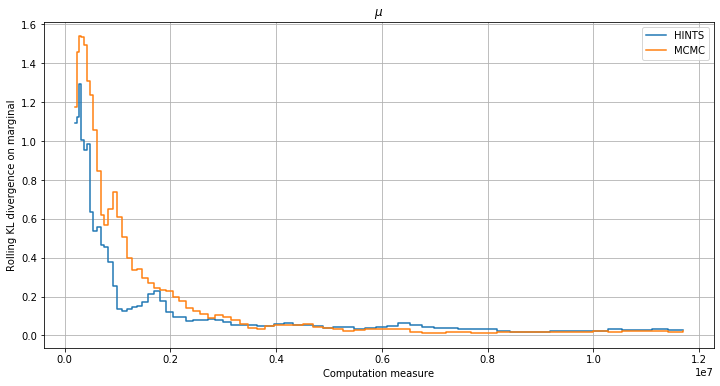

In [379]:
h_roll_kl = [metric(res_HINTS, 'mu', e1, e2, marginal_mu, gmu) for e1, e2 in zip(e1s, e2s)]
mcmc_roll_kl = [metric(res_MCMC, 'mu', e1, e2, marginal_mu, gmu) for e1, e2 in zip(e1s, e2s)]


plt.figure(figsize = [12, 6])
plt.plot(e1s, h_roll_kl, drawstyle = 'steps-post', label = 'HINTS')
plt.plot(e1s, mcmc_roll_kl, drawstyle = 'steps-post', label = 'MCMC')
#plt.semilogx()
plt.grid()
plt.legend()
plt.ylabel('Rolling KL divergence on marginal')
plt.xlabel('Computation measure')
plt.title(r'$\mu$')

Text(0.5, 1.0, '$\\nu$')

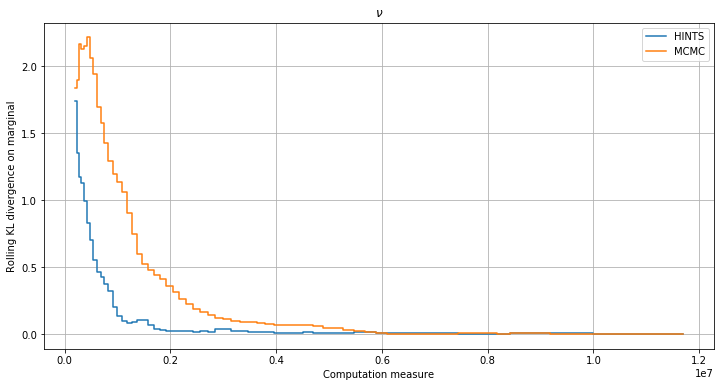

In [380]:
h_roll_kl = [metric_discrete(res_HINTS, 'nu', e1, e2, marginal_nu, gnu) for e1, e2 in zip(e1s, e2s)]
mcmc_roll_kl = [metric_discrete(res_MCMC, 'nu', e1, e2, marginal_nu, gnu) for e1, e2 in zip(e1s, e2s)]


plt.figure(figsize = [12, 6])
plt.plot(e1s, h_roll_kl, drawstyle = 'steps-post', label = 'HINTS')
plt.plot(e1s, mcmc_roll_kl, drawstyle = 'steps-post', label = 'MCMC')
#plt.semilogx()
plt.grid()
plt.legend()
plt.ylabel('Rolling KL divergence on marginal')
plt.xlabel('Computation measure')
plt.title(r'$\nu$')

C:\Users\mjstr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


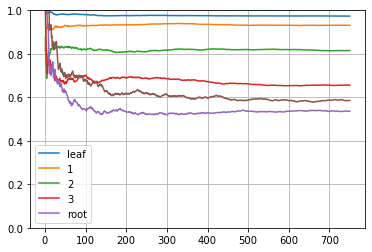

In [381]:
df_HINTS = res_HINTS[0]
A = np.array([np.array(a) for a in df_HINTS['acceptances']])
R = np.array([np.array(r) for r in df_HINTS['rejections']])
plt.plot(A/(A+R))
plt.ylim(0.0, 1.0)
plt.grid()
plt.legend(labels = ['leaf', '1', '2', '3', 'root'])
#df_MCMC = pd.DataFrame(history)

In [25]:
# Now we have a deeper tree should probably use smaller proposals in HINTS

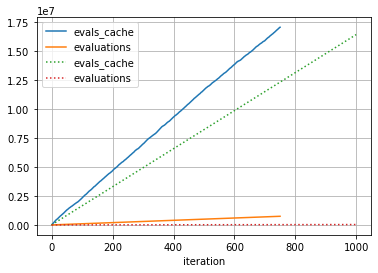

In [221]:
import pandas as pd
df_MCMC = res_MCMC[0]
df_HINTS[['evals_cache', 'evaluations']].plot()
df_MCMC[['evals_cache', 'evaluations']].plot(linestyle = 'dotted', ax = plt.gca())
plt.xlabel('iteration')
plt.grid()

In [27]:
print(df_HINTS.iloc[-1])
print(df_MCMC.iloc[-1])
# without downsampling factor is still 5 if we look at evals_cache
# but with downsampling it is < 1.5

nu                                         9
mu                                  1.003394
tau                                 1.014492
acceptances    [11351, 5224, 2126, 837, 408]
rejections         [649, 776, 874, 663, 342]
evals_cache                         17032896
evaluations                           744000
Name: 750, dtype: object
nu                    8
mu             0.996776
tau            1.001803
acceptances       [130]
rejections        [370]
evals_cache     8208384
evaluations       16000
Name: 500, dtype: object
